In [1]:
using Kinbiont
using DifferentialEquations
using CSV
using SymbolicRegression
using Plots
using StatsBase
using Distributions

In this example, we will use Kinbiont to generate data about a single species. 
We suppose that the growth rate depends on an experimental feature, but its exact effect is unknown.
Specifically, the perturbation follows a **quadratic** dependence: mu = (1 - feature)^2.
The user performs experiments at different conditions and fits the data with a simple model,
where the growth rate is an effective parameter fixed by the experimental condition (i.e., mu(feature) -> mu_eff).
Finally, applying symbolic regression on the fitted results, we retrieve the relationship between the experimental feature and the effective growth rate.

In [2]:
# Defining the function that alters the growth rate (quadratic dependence)
function unknown_response(feature)
    response = (1 - feature)^2
    return response
end

unknown_response (generic function with 1 method)

In [3]:
# Defining the used ODE model
results_fit = Any

Any

In [4]:
ODE_models = "baranyi_richards"

"baranyi_richards"

In [5]:
ub_1 = [0.1, 5.1, 500.0, 5.0]
lb_1 = [0.0001, 0.1, 0.00, 0.2]
p1_guess = lb_1 .+ (ub_1 .- lb_1) ./ 2

4-element Vector{Float64}:
   0.050050000000000004
   2.6
 250.0
   2.6

In [6]:
# Defining the range of the perturbation on feature
feature_range = 0.0:0.2:2.0

0.0:0.2:2.0

In [7]:
# Defining the parameter values for the simulation
p_sim = [0.05, 1.0, 50.0, 1.0]
psim_1_0 = p_sim[1]
t_min = 0.0
t_max = 800.0
n_start = [0.1]
delta_t = 5.0
noise_value = 0.03

0.03

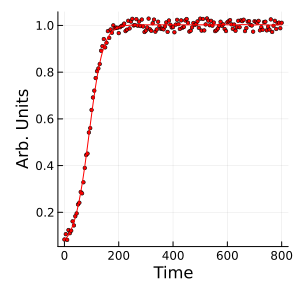

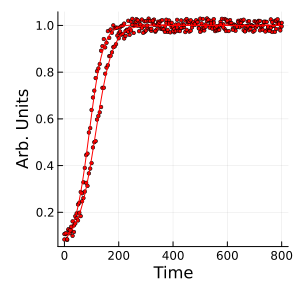

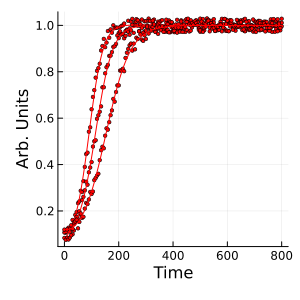

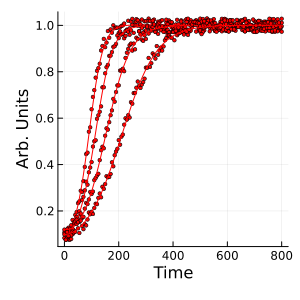

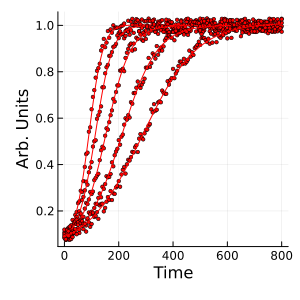

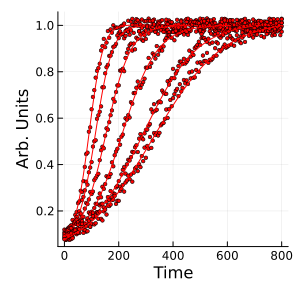

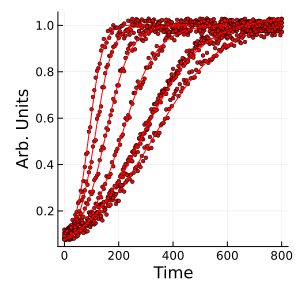

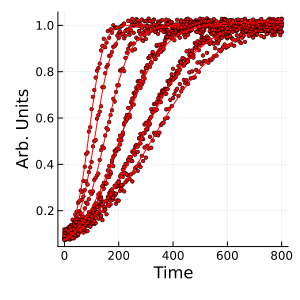

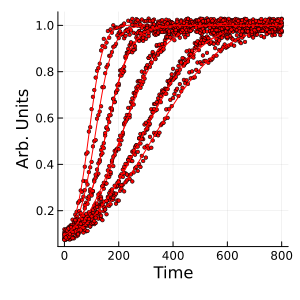

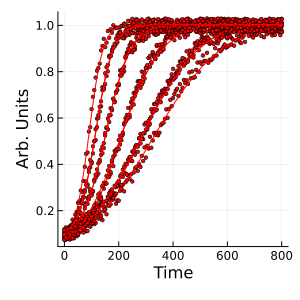

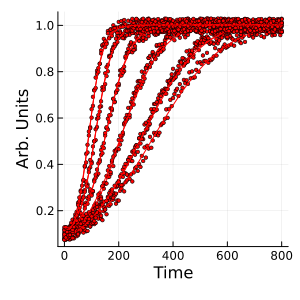

In [8]:
plot(0, 0)
for f in feature_range
    # Changing the parameters with quadratic unknown perturbation
    p_sim[1] = psim_1_0 * unknown_response(f) .+ 0.01

    # Calling the simulation function
    sim = Kinbiont.ODE_sim("baranyi_richards", n_start, t_min, t_max, delta_t, p_sim)

    # Adding uniform random noise
    noise_uniform = rand(Uniform(-noise_value, noise_value), length(sim.t))

    data_t = reduce(hcat, sim.t)
    data_o = reduce(hcat, sim.u)
    data_OD = vcat(data_t, data_o)
    data_OD[2, :] = data_OD[2, :] .+ noise_uniform

    # Plotting scatterplot of data with noise
    Plots.scatter!(data_OD[1, :], data_OD[2, :], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300))

    results_ODE_fit = fitting_one_well_ODE_constrained(
        data_OD,
        string(f),
        "test_ODE",
        "baranyi_richards",
        p1_guess;
        lb=lb_1,
        ub=ub_1
    )

    display(Plots.plot!(results_ODE_fit[4], results_ODE_fit[3], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))

    if f == feature_range[1]
        results_fit = results_ODE_fit[2]
    else
        results_fit = hcat(results_fit, results_ODE_fit[2])
    end
end

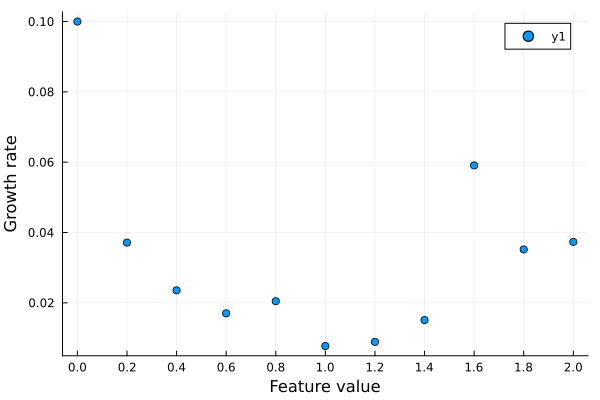

In [9]:
scatter(results_fit[2, :], results_fit[4, :], xlabel="Feature value", ylabel="Growth rate")

In [10]:
# Setting options for symbolic regression
options = SymbolicRegression.Options(
    binary_operators=[+, /, *, -],
    unary_operators=[square],
    constraints=nothing,
    elementwise_loss=nothing,
    loss_function=nothing,
    tournament_selection_n=12,
    tournament_selection_p=0.86,
    topn=12,
    complexity_of_operators=nothing,
    complexity_of_constants=nothing,
    complexity_of_variables=nothing,
    parsimony=0.05,
    dimensional_constraint_penalty=nothing,
    alpha=0.100000,
    maxsize=10,
    maxdepth=nothing
)

Options(binops=Function[+, /, *, -], unaops=Function[SymbolicRegression.CoreModule.OperatorsModule.square], bin_constraints=[(-1, -1), (-1, -1), (-1, -1), (-1, -1)], una_constraints=[-1], complexity_mapping=SymbolicRegression.CoreModule.OptionsStructModule.ComplexityMapping{Int64}(false, Int64[], Int64[], 1, 1), tournament_selection_n=12, tournament_selection_p=0.86, tournament_selection_weights=[0.86, 0.12040000000000001, 0.016856000000000003, 0.0023598400000000006, 0.0003303776000000001, 4.625286400000002e-5, 6.475400960000003e-6, 9.065561344000006e-7, 1.2691785881600008e-7, 1.7768500234240014e-8, 2.4875900327936024e-9, 3.482626045911044e-10], parsimony=0.05, dimensional_constraint_penalty=nothing, alpha=0.1, maxsize=10, maxdepth=10, turbo=false, migration=true, hof_migration=true, should_simplify=true, should_optimize_constants=true, output_file=hall_of_fame_2025-03-24_195817.415.csv, populations=15, perturbation_factor=0.076, annealing=false, batching=false, batch_size=50, mutation

In [11]:
# Generating feature matrix
# The first column is the label as a string of the feature value we used for the fitting labeling
feature_matrix = [[string(f), f] for f in feature_range]
feature_matrix = permutedims(reduce(hcat, feature_matrix))

11×2 Matrix{Any}:
 "0.0"  0.0
 "0.2"  0.2
 "0.4"  0.4
 "0.6"  0.6
 "0.8"  0.8
 "1.0"  1.0
 "1.2"  1.2
 "1.4"  1.4
 "1.6"  1.6
 "1.8"  1.8
 "2.0"  2.0

In [12]:
# Symbolic regression between the feature and the growth rate (4th row of the results_fit)
gr_sy_reg = Kinbiont.downstream_symbolic_regression(results_fit, feature_matrix, 4; options=options)

┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


┣                                              ┫ 0/150 [00:00<00:-7, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           6.594e-04  3.604e+01  y = 0.032859                                  ---------------------------------------------------------------------------------------------------
0.7%┣▎                                         ┫ 1/150 [00:00<Inf:Inf, InfGs/it]Expressions evaluated per second: [.....]. Head worker occupation: NaN%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:           

(Node{Float64}[0.03285866167736077, (0.043002402419247736 / (0.6021512405417011 + x1)), (square(1.0822523176041141 - x1) * 0.06935124238845337), ((square(1.0822523176041141 - x1) - -0.10535152233271279) * 0.06935124238845337), (0.009421758082211306 / ((x1 / square(x1 + 0.7965849347327207)) + 0.09706574103261822))], Any["Complexity" 1 … 8 10; "MSE" 0.0006593527788075547 … 0.00027640642222341946 0.00018039792674367754; "Equation" "0.03285866167736077" … "((square(1.0822523176041141 - x1) - -0.10535152233271279) * 0.06935124238845337)" "(0.009421758082211306 / ((x1 / square(x1 + 0.7965849347327207)) + 0.09706574103261822))"], [0.03285866167736077 0.07141462065337997 … 0.08853529410955009 0.09706574103261824; 0.03285866167736077 0.05360884612010045 … 0.061287126683636894 0.03157015168630708; … ; 0.03285866167736077 0.017901621552167717 … 0.043033365355076986 0.02588119194813474; 0.03285866167736077 0.01652571216817349 … 0.06571809244885021 0.02670632958068042], [1, 2, 3, 4, 5, 6, 7, 8, 9, 

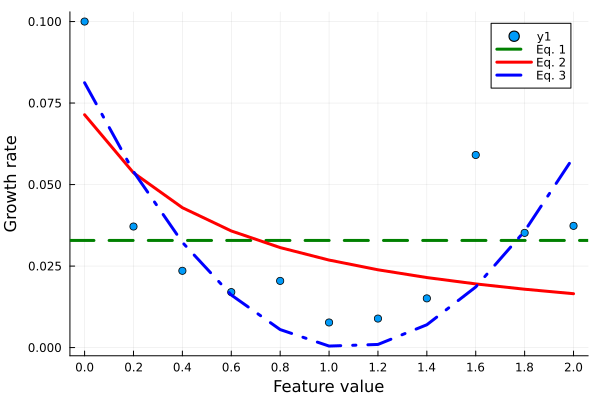

In [13]:
scatter(results_fit[2, :], results_fit[4, :], xlabel="Feature value", ylabel="Growth rate")
hline!(unique(gr_sy_reg[3][:, 1]), label=["Eq. 1" nothing], line=(3, :green, :dash))
plot!(unique(results_fit[2, :]), unique(gr_sy_reg[3][:, 2]), label=["Eq. 2" nothing], line=(3, :red))
plot!(unique(results_fit[2, :]), unique(gr_sy_reg[3][:, 3]), label=["Eq. 3" nothing], line=(3, :blue, :dashdot))